In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from itertools import cycle

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import integrate
from csaps import csaps

from pathlib import Path

In [2]:
def dehnen_profile_2D(r, ro0, a, gamma):
    zeta = np.geomspace(1e-10, 30000, 10001)
    eta = r / a
    ETA, ZETA = np.meshgrid(eta, zeta)
    S = integrate.simps(np.power(ZETA ** 2 + ETA ** 2, - gamma/2) * np.power(1 + np.sqrt(ZETA ** 2 + ETA ** 2), gamma - 4), x=zeta, axis=0)
    return 2 * ro0 * a * S

In [3]:
def dehnen_profile_3D(r, ro0, a, gamma):
    return ro0 * (r / a) ** (- gamma) * (1 + r / a) ** (gamma - 4)

In [4]:
def dmdr_profile_2D(r, ro0, a, gamma):
    return dehnen_profile_2D(r, ro0, a, gamma) * 2 * np.pi * r

In [5]:
def dmdr_profile_3D(r, ro0, a, gamma):
    return dehnen_profile_3D(r, ro0, a, gamma) * 4 * np.pi * r ** 2

In [6]:
def normalize_cluster(cluster):
    cluster['x'] *= R_norm
    cluster['y'] *= R_norm
    cluster['z'] *= R_norm

    cluster['vx'] *= V_norm
    cluster['vy'] *= V_norm
    cluster['vz'] *= V_norm

    cluster['M'] *= M_norm
    cluster['M_ini'] *= M_norm
    
    return cluster

In [7]:
R_norm = 1.2262963200 #pc
V_norm = 4.587330615 #km/s
M_norm = 6.0e3 #Msun
OUTPUT_DIR_1 = Path('./gamma=2.0/run-2.0-0.20-11/')

In [8]:
names = np.array(['M', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M_ini', 'Z', 'Nan', 'Event',
                  'M_', 'Nan3', 'Nan4', 'Nan5', 'Nan6', 'Nan7', 'Nan8'])
files = ['000000.dat', 
         '000100.dat', 
         '000200.dat', 
         '000300.dat', 
         '000400.dat', 
         '000500.dat', 
         '000600.dat', 
         '000700.dat', 
         '000800.dat',
         '000900.dat']

bounds = np.array([[1, 20000], [1e-2, 10], [1e-9, 3]])
init_vals = np.array([100, 0.5, 1])
r_e = np.geomspace(1e-1, 100, 101)
dmdr_3D = pd.DataFrame(data={'r':r_e})
dmdr_2D = pd.DataFrame(data={'r':r_e})
popts_3D = pd.DataFrame()
popts_2D = pd.DataFrame()

In [9]:
density_cs = pd.read_csv(OUTPUT_DIR_1 / 'def-dc.dat', delimiter='\s+', index_col=0, header=None)

### in 3D

In [10]:
for i, file in enumerate(files):
    cluster = pd.read_csv(OUTPUT_DIR_1 / file, 
                          index_col=0, delimiter='\s+', header=3, names=names)
    cluster = normalize_cluster(cluster)

    xc, yc, zc = density_cs.iloc[i * 100, 1:4]
    
    r_sort = np.sort(np.sqrt((cluster['x'] - xc) ** 2 + 
                             (cluster['y'] - yc) ** 2 + 
                             (cluster['z'] - zc) ** 2))
    
    n = np.arange(len(r_sort)) + 1
    n_smoothed = csaps(r_sort, n, smooth=1 - 1e-4)
    dmdr = n_smoothed(r_e, 1)

    popt_dehnen_counts, pcov_dehnen_counts = curve_fit(dmdr_profile_3D, r_e, dmdr, 
                                                       bounds=bounds.T, p0=init_vals, maxfev=7000)
    
    dmdr_3D[i * 100] = dmdr
    popts_3D[i * 100] = popt_dehnen_counts

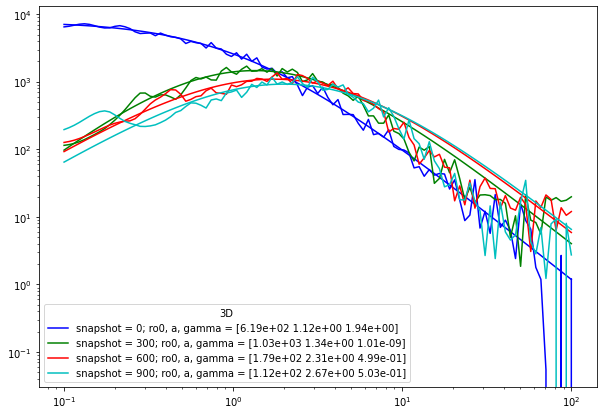

In [11]:
cycol = cycle('bgrcmk')
np.set_printoptions(formatter={'float': "{0:0.2e}".format})

fig, ax = plt.subplots(figsize=(10,7))
for i in range(0, 1000, 300):
    c=next(cycol)
    ax.plot(dmdr_3D['r'], dmdr_3D[i], label=f'snapshot = {i}; ro0, a, gamma = {popts_3D[i].values}', c=c)
    ax.plot(dmdr_3D['r'], dmdr_profile_3D(dmdr_3D['r'], *popts_3D[i]), c=c)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(title='3D')

In [12]:
popts_3D # ro0, a, gamma

,0,100,200,300,400,500,600,700,800,900
0,618.635628,2.085568e+03,1.264678e+03,1.032197e+03,674.829060,5.831542e+02,178.539002,133.998695,98.535935,112.253384
1,1.117450,1.091721e+00,1.280103e+00,1.344542e+00,1.538950,1.628308e+00,2.307879,2.581946,2.806093,2.670276
2,1.941571,1.000129e-09,1.000000e-09,1.005928e-09,0.046592,1.000018e-09,0.499037,0.510149,0.582162,0.503002


### in 2D

In [13]:
for i, file in enumerate(files):
    cluster = pd.read_csv(OUTPUT_DIR_1 / file, 
                          index_col=0, delimiter='\s+', header=3, names=names)
    cluster = normalize_cluster(cluster)

    xc, yc, zc = density_cs.iloc[i * 100, 1:4]
    
    r_sort = np.sort(np.sqrt((cluster['x'] - xc) ** 2 + 
                             (cluster['y'] - yc) ** 2))
    
    n = np.arange(len(r_sort)) + 1
    n_smoothed = csaps(r_sort, n, smooth=1 - 1e-4)
    dmdr = n_smoothed(r_e, 1)

    popt_dehnen_counts, pcov_dehnen_counts = curve_fit(dmdr_profile_2D, r_e, dmdr, 
                                                       bounds=bounds.T, p0=init_vals, maxfev=7000)
    
    dmdr_2D[i * 100] = dmdr
    popts_2D[i * 100] = popt_dehnen_counts

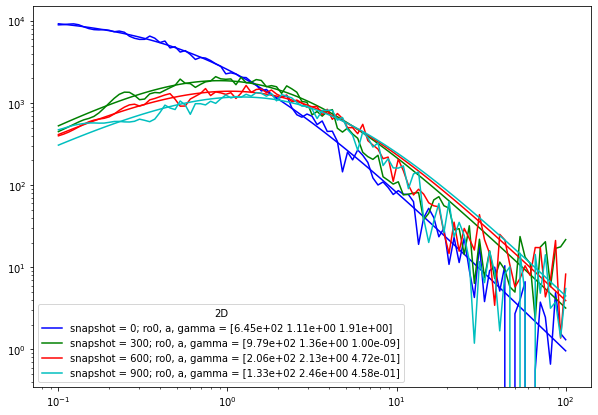

In [14]:
cycol = cycle('bgrcmk')
np.set_printoptions(formatter={'float': "{0:0.2e}".format})

fig, ax = plt.subplots(figsize=(10,7))
for i in range(0, 1000, 300):
    c=next(cycol)
    ax.plot(dmdr_2D['r'], dmdr_2D[i], label=f'snapshot = {i}; ro0, a, gamma = {popts_2D[i].values}', c=c)
    ax.plot(dmdr_2D['r'], dmdr_profile_2D(dmdr_2D['r'], *popts_2D[i]), c=c)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(title='2D')

In [15]:
popts_2D # ro0, a, gamma

,0,100,200,300,400,500,600,700,800,900
0,645.071901,2.282009e+03,1.225703e+03,9.785604e+02,7.056713e+02,5.225808e+02,205.584807,153.858074,143.446174,132.579445
1,1.114387,1.025839e+00,1.274299e+00,1.363989e+00,1.507814e+00,1.677391e+00,2.131882,2.333571,2.424136,2.463666
2,1.912425,1.000065e-09,1.000029e-09,1.000004e-09,1.000003e-09,1.000046e-09,0.471979,0.495668,0.458230,0.458280
